In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
 
from sklearn.preprocessing import MinMaxScaler
 
%matplotlib notebook
import matplotlib.pyplot as plt

### 1. Модель

#### Scaled Dot-Product Attention

Функция внимания, используемая преобразователем, принимает три входа: Q (запрос), K (ключ), V (значение). Уравнение, используемое для расчета весов внимания:


$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [ ]:
def attention(Q, K, V):
    m = torch.matmul(Q, K.transpose(2, 1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())

    a = torch.softmax(m , -1) #(batch_size, dim_attn, seq_length)
    
    return  torch.matmul(a,  V) #(batch_size, seq_length, seq_length)

class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn):
        super(AttentionBlock, self).__init__()
        self.query = Query(dim_val, dim_attn)
        self.key = Key(dim_val, dim_attn)
        self.value = Value(dim_val, dim_val)        
        
    
    def forward(self, x, kv = None):
        if(kv is None):
            #Attention with x connected to Q, K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        
        #Attention with x as Q, external vector kv as K an V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))

    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.heads = nn.ModuleList(self.heads)
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
        
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.dim_val = dim_val
        
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False)
        #self.fc2 = nn.Linear(5, dim_val)
    
    def forward(self, x):
        x = self.fc1(x)
        #x = self.fc2(x)
        
        return x

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        x = self.fc1(x)
        #x = self.fc2(x)
        
        return x

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        
        x = self.fc1(x)
        #print(x.shape)
        #x = self.fc2(x)
        
        return x

# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]. squeeze(1)
        return x     
    
def get_data(data, batch_size, input_sequence_length, output_sequence_length, train=True):
  """
  train, test: np.array, shape(n, )

  """  
  i = input_sequence_length + output_sequence_length
  if train:
    t = torch.zeros(batch_size, 1).uniform_(0, len(instrument_data) - i).int()
  else:    
    batch_size = len(data) - i
    t = torch.arange(0, batch_size).reshape(-1, 1)
  
  b = torch.arange(0, i).unsqueeze(0).repeat(batch_size, 1) + t
  s = torch.FloatTensor(data[b])
  X, y = s[:, :input_sequence_length].unsqueeze(-1), s[:,-output_sequence_length:]

  return X, y

In [ ]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionBlock(dim_val, dim_attn , n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
    
    def forward(self, x):
        a = self.attn(x)
        x = self.norm1(x + a)
        
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm2(x + a)
        
        return x

class DecoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.attn2 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        self.norm3 = nn.LayerNorm(dim_val)
        
    def forward(self, x, enc):
        a = self.attn1(x)
        x = self.norm1(a + x)
        
        a = self.attn2(x, kv = enc)
        x = self.norm2(a + x)
        
        a = self.fc1(F.elu(self.fc2(x)))
        
        x = self.norm3(x + a)
        return x

class Transformer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, dec_seq_len, out_seq_len, 
                 n_decoder_layers = 1, n_encoder_layers = 1, n_heads = 1):
        super(Transformer, self).__init__()
        self.dec_seq_len = dec_seq_len
        
        #Initiate encoder and Decoder layers
        self.encs = []
        for i in range(n_encoder_layers):
            self.encs.append(EncoderLayer(dim_val, dim_attn, n_heads))
        
        self.decs = []
        for i in range(n_decoder_layers):
            self.decs.append(DecoderLayer(dim_val, dim_attn, n_heads))
        
        self.pos = PositionalEncoding(dim_val)
        
        #Dense layers for managing network inputs and outputs
        self.enc_input_fc = nn.Linear(input_size, dim_val)
        self.dec_input_fc = nn.Linear(input_size, dim_val)
        self.out_fc = nn.Linear(dec_seq_len * dim_val, out_seq_len)
    
    def forward(self, x):
        #encoder
        e = self.encs[0](self.pos(self.enc_input_fc(x)))
        for enc in self.encs[1:]:
            e = enc(e)
        
        #decoder
        d = self.decs[0](self.dec_input_fc(x[:,-self.dec_seq_len:]), e)
        for dec in self.decs[1:]:
            d = dec(d, e)
            
        #output
        x = self.out_fc(d.flatten(start_dim=1))
        
        return x

### 2. Гиперпраметры модели

In [ ]:
#hyperparams
enc_seq_len = 10
dec_seq_len = 4
output_sequence_length = 1

dim_val = 10
dim_attn = 9
input_size = 1 # число признаков
lr = 0.002
epochs = 20

n_heads = 3 

n_decoder_layers = 3
n_encoder_layers = 3

batch_size = 15

#init network and optimizer
t = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

#keep track of loss for graph
losses = []

### 3. Подготовка данных для модели

В качестве иммитации данных одного инструмента instrument_data использовалалась функция сos(x) при х от 0 до 100 - train и от 100 до 150 - test.

Вместо instrument_data и test_data можно вводить данные временного ряда любого ОДНОГО инструмента.

In [ ]:
def get_dummy_data(x):
  return np.cos(x)

x = np.arange(100, dtype=np.float32)
instrument_data = get_dummy_data(x)

scaler = MinMaxScaler()
instrument_data = scaler.fit_transform(instrument_data.reshape(-1, 1)).flatten()

In [ ]:
test_data = np.arange(100, 150, dtype=np.float32)
test_data = get_dummy_data(test_data)
true_seq = test_data.copy()

test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()
X_test, y_test = get_data(test_data, batch_size, enc_seq_len, output_sequence_length, False)
X_test.shape, y_test.shape

(torch.Size([39, 10, 1]), torch.Size([39, 1]))

### 4. Обучение модели

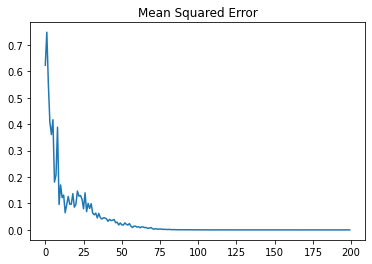

In [ ]:
#build live matplotlib fig
fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

    
for e in range(epochs):
    out = []
    
    for b in range(enc_seq_len):
        optimizer.zero_grad()
        X, y = get_data(instrument_data, batch_size, enc_seq_len, output_sequence_length)
        
        #Forward pass and calculate loss
        net_out = t(X)
        #print(net_out.shape,Y.shape)
        loss = torch.mean((net_out - y) ** 2)

        #backwards pass
        loss.backward()
        optimizer.step()

        #Track losses and draw rgaph
        out.append([net_out.detach().numpy(), y])
        losses.append(loss)

        ax.clear()
        ax.plot(losses)
        ax.set_title("Mean Squared Error")
        fig.canvas.draw()

### 5. Предсказания модели

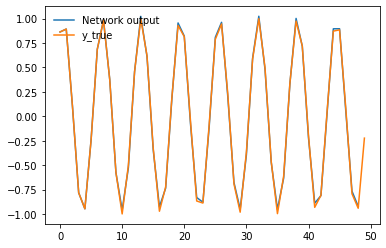

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
#true_seq = scaler.inverse_transform(instrument_data.reshape(-1, 1))
x = [X_test[0].tolist()]
N = X_test.shape[0] #- (enc_seq_len + output_sequence_length)

#Draw graph 
for i in range(N): 
  q = torch.tensor([X_test[i].tolist()]).float()  
  
  #if(output_sequence_length == 1):
  y_pred = [t(q).detach().squeeze().numpy()]
  
  x[0].append(y_pred)

prediction = scaler.inverse_transform(x[0])
ax.clear()
ax.plot(prediction, label='Network output')
ax.plot(true_seq, label='y_true')
ax.set_title("")
ax.legend(loc='upper left', frameon=False);

### 6. Оценка качества предсказаний

#### Pearson product-moment correlation coefficients

In [ ]:
prediction = prediction.flatten()

np.corrcoef(prediction, true_seq[:-1])

array([[1.       , 0.9995844],
       [0.9995844, 1.       ]])

#### RMSE

In [ ]:
np.sqrt(((prediction - true_seq[:-1])**2).sum())

0.14726974490111194